In [ ]:
MP2_data = pd.read_csv("MP2_Processed.csv") 
MediaPipe = pd.read_csv("MediaPipe_MP2_Processed.csv") 

# Extract features and target variable
# Assuming the last column in each dataframe is the target (the column you want to predict)
MP2_features = MP2_data.iloc[:, 2:-1].values  # All columns except the first and last (image name and target)
MP2_target = MP2_data.iloc[:, -1].values  # Last column is the target

MediaPipe_features = MediaPipe.iloc[:, 2:-1].values
MediaPipe_target = MediaPipe.iloc[:, -1].values

In [19]:
MP2_features

array([[ 895.,  293.,  910., ...,  203.,  955.,  263.],
       [   0.,    0.,    0., ...,  516.,  545.,  466.],
       [ 804.,  711.,  816., ...,  353., 1142.,  478.],
       ...,
       [ 562.,  617.,  558., ...,  411.,  461.,  414.],
       [ 496.,  377.,  466., ...,  293.,  410.,  325.],
       [ 362.,  350.,  347., ...,  199.,  268.,  194.]])

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, mean_squared_error, explained_variance_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, GlobalAveragePooling1D, MultiHeadAttention
from tensorflow.keras import Input
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

# Load the datasets
MP2_data = pd.read_csv("MP2_Processed.csv")
MediaPipe_data = pd.read_csv("MediaPipe_MP2_Processed.csv")

# Drop the 'image' column and use 'act_id' as the target column
MP2_data = MP2_data.drop(columns=['image'])  # Drop 'image' column
MediaPipe_data = MediaPipe_data.drop(columns=['image'])  # Drop 'image' column

# Features and targets for MP2 data
X_MP2 = MP2_data.drop(columns=['act_id']).values  # Features
y_MP2 = MP2_data['act_id'].values  # Target variable

# Features and targets for MediaPipe data
X_MediaPipe = MediaPipe_data.drop(columns=['act_id']).values  # Features
y_MediaPipe = MediaPipe_data['act_id'].values  # Target variable

# Split the data into training and testing sets
X_train_MP2, X_test_MP2, y_train_MP2, y_test_MP2 = train_test_split(X_MP2, y_MP2, test_size=0.2, random_state=42)
X_train_MediaPipe, X_test_MediaPipe, y_train_MediaPipe, y_test_MediaPipe = train_test_split(X_MediaPipe, y_MediaPipe, test_size=0.2, random_state=42)

# One-hot encoding the target labels
y_train_MP2_encoded = to_categorical(y_train_MP2, num_classes=1000)  # Assuming 700 classes
y_test_MP2_encoded = to_categorical(y_test_MP2, num_classes=1000)

y_train_MediaPipe_encoded = to_categorical(y_train_MediaPipe, num_classes=1000)  # Assuming 700 classes
y_test_MediaPipe_encoded = to_categorical(y_test_MediaPipe, num_classes=1000)

# Define a Dense model for multi-class classification
# Define a Dense model with 20 hidden layers for multi-class classification
def create_dense_model(input_shape):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape))
    # Add 20 hidden layers
    for _ in range(10):
        model.add(Dense(128, activation='relu'))
    model.add(Dense(1000, activation='softmax'))  # 1000 output classes
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a Transformer model with 20 hidden layers
def create_transformer_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Use Dense layer for embedding
    x = Dense(128, activation='relu')(inputs)  # Initial dense layer
    
    # Add 20 hidden layers
    for _ in range(10):
        x = Dense(128, activation='relu')(x)
    
    # Use Reshape to match the expected input shape for the attention layer
    x = Reshape((-1, 128))(x)  # Reshaping to match the attention input format
    
    # MultiHeadAttention layer
    attention_output = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
    
    # Add a Dense layer to match the number of output classes
    x = GlobalAveragePooling1D()(attention_output)  # Reduce to a fixed-size vector
    x = Dense(1000, activation='softmax')(x)  # 1000 output classes
    
    model = tf.keras.Model(inputs, x)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Select the models for the task (Dense and Transformer)
models = {
    "Dense": create_dense_model(X_train_MP2.shape[1:]),
    "Transformer": create_transformer_model(X_train_MP2.shape[1:])
}

# Train, evaluate, and calculate metrics
results = {}
consistency_scores = {}

for model_name, model in models.items():
    print(f"Training {model_name} on MP2 Data...")
    model.fit(X_train_MP2, y_train_MP2_encoded, epochs=500, batch_size=64, validation_split=0.2, verbose=1)
    mp2_preds = model.predict(X_test_MP2)
    mp2_accuracy = model.evaluate(X_test_MP2, y_test_MP2_encoded, verbose=0)
    mp2_report = classification_report(y_test_MP2, np.argmax(mp2_preds, axis=1), output_dict=True)

    print(f"Training {model_name} on MediaPipe Data...")
    model.fit(X_train_MediaPipe, y_train_MediaPipe_encoded, epochs=500, batch_size=64, validation_split=0.2, verbose=1)
    mediapipe_preds = model.predict(X_test_MediaPipe)
    mediapipe_accuracy = model.evaluate(X_test_MediaPipe, y_test_MediaPipe_encoded, verbose=0)
    mediapipe_report = classification_report(y_test_MediaPipe, np.argmax(mediapipe_preds, axis=1), output_dict=True)

    # Store results for each model
    results[model_name] = {
        "MP2": {
            "Accuracy": mp2_accuracy[1],  # Use accuracy from model evaluation
        },
        "MediaPipe": {
            "Accuracy": mediapipe_accuracy[1],  # Use accuracy from model evaluation
        }
    }

    # Store classification report results for each class
    for class_label in range(1000):  # Assuming 1000 classes
        class_label_str = str(class_label)
        
        # Check if the class exists in the classification report
        if class_label_str in mp2_report:
            results[model_name]["MP2"][f"Precision_{class_label_str}"] = mp2_report[class_label_str]["precision"]
            results[model_name]["MP2"][f"Recall_{class_label_str}"] = mp2_report[class_label_str]["recall"]
            results[model_name]["MP2"][f"F1-Score_{class_label_str}"] = mp2_report[class_label_str]["f1-score"]
        else:
            results[model_name]["MP2"][f"Precision_{class_label_str}"] = np.nan
            results[model_name]["MP2"][f"Recall_{class_label_str}"] = np.nan
            results[model_name]["MP2"][f"F1-Score_{class_label_str}"] = np.nan
        
        if class_label_str in mediapipe_report:
            results[model_name]["MediaPipe"][f"Precision_{class_label_str}"] = mediapipe_report[class_label_str]["precision"]
            results[model_name]["MediaPipe"][f"Recall_{class_label_str}"] = mediapipe_report[class_label_str]["recall"]
            results[model_name]["MediaPipe"][f"F1-Score_{class_label_str}"] = mediapipe_report[class_label_str]["f1-score"]
        else:
            results[model_name]["MediaPipe"][f"Precision_{class_label_str}"] = np.nan
            results[model_name]["MediaPipe"][f"Recall_{class_label_str}"] = np.nan
            results[model_name]["MediaPipe"][f"F1-Score_{class_label_str}"] = np.nan

# Visualization (unchanged)
metric_labels = ["Accuracy"]
manual_metrics = [[results[m]["MP2"][metric] for m in models.keys()] for metric in metric_labels]
mediapipe_metrics = [[results[m]["MediaPipe"][metric] for m in models.keys()] for metric in metric_labels]

plt.figure(figsize=(10, 8))
x = np.arange(len(models))

# Plot extended metrics
for i, metric in enumerate(metric_labels):
    plt.subplot(1, 1, i + 1)
    plt.bar(x - 0.2, [manual_metrics[i][j] for j in range(len(models))], 0.4, label='MP2', color='blue')
    plt.bar(x + 0.2, [mediapipe_metrics[i][j] for j in range(len(models))], 0.4, label='MediaPipe', color='green')
    plt.title(metric)
    plt.xticks(x, models.keys())
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()

/Users/dhruv/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Dense on MP2 Data...
Epoch 1/500
158/158 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.0044 - loss: 6.5358 - val_accuracy: 0.0079 - val_loss: 6.2025
Epoch 2/500
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0114 - loss: 6.1369 - val_accuracy: 0.0095 - val_loss: 6.0957
Epoch 3/500
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0104 - loss: 5.9410 - val_accuracy: 0.0091 - val_loss: 5.7433
Epoch 4/500
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0116 - loss: 5.6355 - val_accuracy: 0.0178 - val_loss: 5.4869
Epoch 5/500
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0207 - loss: 5.3341 - val_accuracy: 0.0269 - val_loss: 5.1361
Epoch 6/500
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0283 - loss: 5.1089 - val_accuracy: 0.0309 - val_loss: 4.9595
Epoch 7/500
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.0357 - loss: 4.8869 - val_accuracy: 0.0360 - val_loss: 4.9181
Epoch 8/500
158/158 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.

KeyboardInterrupt: 

/Users/dhruv/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Dense on MP2 Data...
Epoch 1/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.0074 - loss: 6.7771 - val_accuracy: 0.0214 - val_loss: 5.6654
Epoch 2/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0153 - loss: 5.5415 - val_accuracy: 0.0162 - val_loss: 5.4700
Epoch 3/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0244 - loss: 5.3519 - val_accuracy: 0.0237 - val_loss: 5.3390
Epoch 4/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0268 - loss: 5.1602 - val_accuracy: 0.0336 - val_loss: 5.1650
Epoch 5/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0354 - loss: 5.0157 - val_accuracy: 0.0360 - val_loss: 5.1508
Epoch 6/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0390 - loss: 4.8808 - val_accuracy: 0.0416 - val_loss: 4.9881
Epoch 7/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0481 - loss: 4.7649 - val_accuracy: 0.0483 - val_loss: 4.8693
Epoch 8/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.

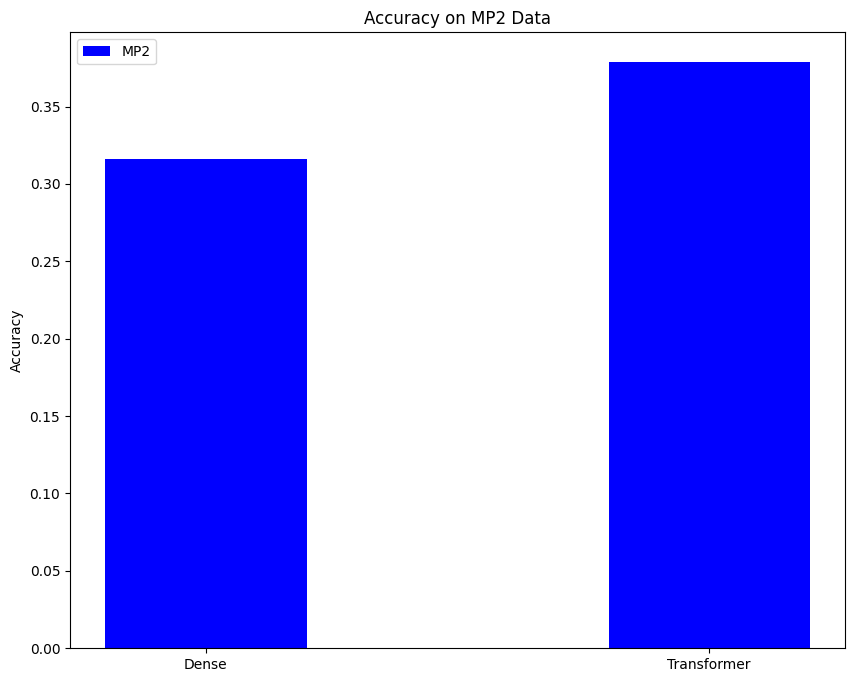

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling1D, MultiHeadAttention, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Load the datasets
MP2_data = pd.read_csv("MP2_Processed.csv")
MediaPipe_data = pd.read_csv("MediaPipe_MP2_Processed.csv")

# Drop the 'image' column and use 'act_id' as the target column
MP2_data = MP2_data.drop(columns=['image'])  # Drop 'image' column
MediaPipe_data = MediaPipe_data.drop(columns=['image'])  # Drop 'image' column

# Features and targets for MP2 data
X_MP2 = MP2_data.drop(columns=['act_id']).values  # Features
y_MP2 = MP2_data['act_id'].values  # Target variable

# Features and targets for MediaPipe data
X_MediaPipe = MediaPipe_data.drop(columns=['act_id']).values  # Features
y_MediaPipe = MediaPipe_data['act_id'].values  # Target variable

# Split the data into training and testing sets
X_train_MP2, X_test_MP2, y_train_MP2, y_test_MP2 = train_test_split(X_MP2, y_MP2, test_size=0.2, random_state=42)
X_train_MediaPipe, X_test_MediaPipe, y_train_MediaPipe, y_test_MediaPipe = train_test_split(X_MediaPipe, y_MediaPipe, test_size=0.2, random_state=42)

# One-hot encoding the target labels
y_train_MP2_encoded = to_categorical(y_train_MP2, num_classes=1000)
y_test_MP2_encoded = to_categorical(y_test_MP2, num_classes=1000)
y_train_MediaPipe_encoded = to_categorical(y_train_MediaPipe, num_classes=1000)
y_test_MediaPipe_encoded = to_categorical(y_test_MediaPipe, num_classes=1000)

# Define a Dense model with 10 hidden layers for multi-class classification
def create_dense_model(input_shape):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape))
    # Add 10 hidden layers
    for _ in range(10):
        model.add(Dense(128, activation='relu'))
    model.add(Dense(1000, activation='softmax'))  # 1000 output classes
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a Transformer model with 10 hidden layers
def create_transformer_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(128, activation='relu')(inputs)
    # Add 10 hidden layers
    for _ in range(10):
        x = Dense(128, activation='relu')(x)
    x = Reshape((-1, 128))(x)
    attention_output = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
    x = GlobalAveragePooling1D()(attention_output)
    x = Dense(1000, activation='softmax')(x)
    model = Model(inputs, x)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


# Define a GAN model with 10 hidden layers
def create_gan_model(input_shape):
    generator = Sequential()
    generator.add(Dense(128, activation='relu', input_dim=input_shape[0]))
    # Add 10 hidden layers
    for _ in range(10):
        generator.add(Dense(128, activation='relu'))
    generator.add(Dense(input_shape[0], activation='tanh'))
    
    discriminator = Sequential()
    discriminator.add(Dense(128, activation='relu', input_shape=(input_shape[0],)))
    # Add 10 hidden layers
    for _ in range(10):
        discriminator.add(Dense(128, activation='relu'))
    discriminator.add(Dense(1, activation='sigmoid'))
    
    discriminator.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    gan = Sequential([generator, discriminator])
    gan.compile(optimizer=Adam(), loss='binary_crossentropy')
    
    return gan

# Initialize the models
models = {
    "Dense": create_dense_model(X_train_MP2.shape[1:]),
    "Transformer": create_transformer_model(X_train_MP2.shape[1:]),
    "GAN": create_gan_model(X_train_MP2.shape[1:])
}

# Train and evaluate models
results = {}
for model_name, model in models.items():
    print(f"Training {model_name} on MP2 Data...")
    if model_name != "GAN":
        model.fit(X_train_MP2, y_train_MP2_encoded, epochs=500, batch_size=32, validation_split=0.2, verbose=1)
        mp2_preds = model.predict(X_test_MP2)
        mp2_accuracy = model.evaluate(X_test_MP2, y_test_MP2_encoded, verbose=0)
        results[model_name] = {"MP2 Accuracy": mp2_accuracy[1]}
    else:
        print("GAN model training skipped for classification.")

# Plot results
metric_labels = ["Accuracy"]
mp2_metrics = [[results[m]["MP2 Accuracy"] for m in models if m != "GAN"]]

plt.figure(figsize=(10, 8))
x = np.arange(len(models) - 1)

plt.bar(x, [mp2_metrics[0][j] for j in range(len(models) - 1)], 0.4, label='MP2', color='blue')
plt.xticks(x, [m for m in models if m != "GAN"])
plt.title("Accuracy on MP2 Data")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have predictions and true labels for manual and automated annotations
y_true = # true labels (manual annotations)
y_pred_manual = # predicted labels (manual annotations)
y_pred_auto = # predicted labels (automated annotations)

# Calculate precision, recall, and F1 score for manual vs automated annotations
precision_manual = precision_score(y_true, y_pred_manual, average='weighted')
recall_manual = recall_score(y_true, y_pred_manual, average='weighted')
f1_manual = f1_score(y_true, y_pred_manual, average='weighted')

precision_auto = precision_score(y_true, y_pred_auto, average='weighted')
recall_auto = recall_score(y_true, y_pred_auto, average='weighted')
f1_auto = f1_score(y_true, y_pred_auto, average='weighted')

# Print the results
print(f"Manual Precision: {precision_manual}")
print(f"Manual Recall: {recall_manual}")
print(f"Manual F1 Score: {f1_manual}")
print(f"Automated Precision: {precision_auto}")
print(f"Automated Recall: {recall_auto}")
print(f"Automated F1 Score: {f1_auto}")

from sklearn.metrics import cohen_kappa_score

# Calculate Cohen's Kappa for manual vs automated annotations
kappa = cohen_kappa_score(y_pred_manual, y_pred_auto)

print(f"Cohen's Kappa: {kappa}")

# Calculate error rate
errors_manual = sum(y_true != y_pred_manual)
errors_auto = sum(y_true != y_pred_auto)

error_rate_manual = errors_manual / len(y_true) * 100
error_rate_auto = errors_auto / len(y_true) * 100

print(f"Manual Error Rate: {error_rate_manual}%")
print(f"Automated Error Rate: {error_rate_auto}%")



SyntaxError: invalid syntax (380495790.py, line 4)

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, cohen_kappa_score
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling1D, MultiHeadAttention, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Load the datasets
MP2_data = pd.read_csv("MP2_Processed.csv")
MediaPipe_data = pd.read_csv("MediaPipe_MP2_Processed.csv")

# Drop the 'image' column and use 'act_id' as the target column
MP2_data = MP2_data.drop(columns=['image'])  # Drop 'image' column
MediaPipe_data = MediaPipe_data.drop(columns=['image'])  # Drop 'image' column

# Features and targets for MP2 data
X_MP2 = MP2_data.drop(columns=['act_id']).values  # Features
y_MP2 = MP2_data['act_id'].values  # Target variable

# Features and targets for MediaPipe data
X_MediaPipe = MediaPipe_data.drop(columns=['act_id']).values  # Features
y_MediaPipe = MediaPipe_data['act_id'].values  # Target variable

# Split the data into training and testing sets
X_train_MP2, X_test_MP2, y_train_MP2, y_test_MP2 = train_test_split(X_MP2, y_MP2, test_size=0.2, random_state=42)
X_train_MediaPipe, X_test_MediaPipe, y_train_MediaPipe, y_test_MediaPipe = train_test_split(X_MediaPipe, y_MediaPipe, test_size=0.2, random_state=42)

# One-hot encoding the target labels
y_train_MP2_encoded = to_categorical(y_train_MP2, num_classes=1000)
y_test_MP2_encoded = to_categorical(y_test_MP2, num_classes=1000)
y_train_MediaPipe_encoded = to_categorical(y_train_MediaPipe, num_classes=1000)
y_test_MediaPipe_encoded = to_categorical(y_test_MediaPipe, num_classes=1000)

def create_dense_model(input_shape):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape))
    # Add 20 hidden layers
    for _ in range(10):
        model.add(Dense(128, activation='relu'))
    model.add(Dense(1000, activation='softmax'))  # 1000 output classes
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define a Transformer model with 20 hidden layers
def create_transformer_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Use Dense layer for embedding
    x = Dense(128, activation='relu')(inputs)  # Initial dense layer
    
    # Add 20 hidden layers
    for _ in range(10):
        x = Dense(128, activation='relu')(x)
    
    # Use Reshape to match the expected input shape for the attention layer
    x = Reshape((-1, 128))(x)  # Reshaping to match the attention input format
    
    # MultiHeadAttention layer
    attention_output = MultiHeadAttention(num_heads=8, key_dim=64)(x, x)
    
    # Add a Dense layer to match the number of output classes
    x = GlobalAveragePooling1D()(attention_output)  # Reduce to a fixed-size vector
    x = Dense(1000, activation='softmax')(x)  # 1000 output classes
    
    model = tf.keras.Model(inputs, x)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize the models
models = {
    "Dense": create_dense_model(X_train_MP2.shape[1:]),
    "Transformer": create_transformer_model(X_train_MP2.shape[1:]),
    "GAN": create_gan_model(X_train_MP2.shape[1:])
}

# Train, evaluate, and calculate metrics for each model on both MP2 and MediaPipe datasets
results = {}
for model_name, model in models.items():
    print(f"Training {model_name} on MP2 Data...")
    model.fit(X_train_MP2, y_train_MP2_encoded, epochs=500, batch_size=32, validation_split=0.2, verbose=1)
    mp2_preds = model.predict(X_test_MP2)
    mp2_accuracy = model.evaluate(X_test_MP2, y_test_MP2_encoded, verbose=0)
    mp2_report = classification_report(y_test_MP2, np.argmax(mp2_preds, axis=1), output_dict=True)

    print(f"Training {model_name} on MediaPipe Data...")
    model.fit(X_train_MediaPipe, y_train_MediaPipe_encoded, epochs=500, batch_size=32, validation_split=0.2, verbose=1)
    mediapipe_preds = model.predict(X_test_MediaPipe)
    mediapipe_accuracy = model.evaluate(X_test_MediaPipe, y_test_MediaPipe_encoded, verbose=0)
    mediapipe_report = classification_report(y_test_MediaPipe, np.argmax(mediapipe_preds, axis=1), output_dict=True)

    # Store results for each model
    results[model_name] = {
        "MP2": {
            "Accuracy": mp2_accuracy[1],  # Use accuracy from model evaluation
            "Classification Report": mp2_report
        },
        "MediaPipe": {
            "Accuracy": mediapipe_accuracy[1],  # Use accuracy from model evaluation
            "Classification Report": mediapipe_report
        }
    }

    # Calculate and print evaluation metrics for MP2 and MediaPipe
    for dataset_name, dataset_data in [("MP2", mp2_report), ("MediaPipe", mediapipe_report)]:
        print(f"Metrics for {model_name} on {dataset_name} Data:")
        precision = precision_score(y_test_MP2 if dataset_name == "MP2" else y_test_MediaPipe, np.argmax(mp2_preds if dataset_name == "MP2" else mediapipe_preds, axis=1), average='weighted')
        recall = recall_score(y_test_MP2 if dataset_name == "MP2" else y_test_MediaPipe, np.argmax(mp2_preds if dataset_name == "MP2" else mediapipe_preds, axis=1), average='weighted')
        f1 = f1_score(y_test_MP2 if dataset_name == "MP2" else y_test_MediaPipe, np.argmax(mp2_preds if dataset_name == "MP2" else mediapipe_preds, axis=1), average='weighted')
        
        # Calculate Cohen's Kappa
        kappa = cohen_kappa_score(np.argmax(mp2_preds if dataset_name == "MP2" else mediapipe_preds, axis=1), y_test_MP2 if dataset_name == "MP2" else y_test_MediaPipe)
        
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1 Score: {f1:.4f}")
        print(f"  Cohen's Kappa: {kappa:.4f}")
        print("-" * 50)

# Visualization (unchanged)
metric_labels = ["Accuracy"]
mp2_metrics = [[results[m]["MP2"]["Accuracy"] for m in models]]
mediapipe_metrics = [[results[m]["MediaPipe"]["Accuracy"] for m in models]]

plt.figure(figsize=(10, 8))
x = np.arange(len(models))

# Plot extended metrics
for i, metric in enumerate(metric_labels):
    plt.subplot(1, 1, i + 1)
    plt.bar(x - 0.2, [mp2_metrics[i][j] for j in range(len(models))], 0.4, label='MP2', color='blue')
    plt.bar(x + 0.2, [mediapipe_metrics[i][j] for j in range(len(models))], 0.4, label='MediaPipe', color='green')
    plt.title(metric)
    plt.xticks(x, models.keys())
    plt.ylabel(metric)
    plt.legend()

plt.tight_layout()
plt.show()

/Users/dhruv/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Dense on MP2 Data...
Epoch 1/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.0069 - loss: 7.4862 - val_accuracy: 0.0154 - val_loss: 5.7041
Epoch 2/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0161 - loss: 5.5820 - val_accuracy: 0.0210 - val_loss: 5.5815
Epoch 3/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0236 - loss: 5.3109 - val_accuracy: 0.0233 - val_loss: 5.3959
Epoch 4/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0300 - loss: 5.1509 - val_accuracy: 0.0293 - val_loss: 5.2325
Epoch 5/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.0309 - loss: 5.0513 - val_accuracy: 0.0289 - val_loss: 5.1710
Epoch 6/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0305 - loss: 4.9733 - val_accuracy: 0.0412 - val_loss: 5.1102
Epoch 7/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0429 - loss: 4.8641 - val_accuracy: 0.0408 - val_loss: 5.0774
Epoch 8/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.

/Users/dhruv/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dhruv/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dhruv/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users

Training Dense on MediaPipe Data...
Epoch 1/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1654 - loss: 5.0119 - val_accuracy: 0.1417 - val_loss: 4.3529
Epoch 2/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2163 - loss: 3.0530 - val_accuracy: 0.2224 - val_loss: 3.8585
Epoch 3/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2590 - loss: 2.7615 - val_accuracy: 0.2446 - val_loss: 3.8172
Epoch 4/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2723 - loss: 2.7035 - val_accuracy: 0.2271 - val_loss: 3.8030
Epoch 5/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2845 - loss: 2.6565 - val_accuracy: 0.2576 - val_loss: 3.6792
Epoch 6/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2996 - loss: 2.5593 - val_accuracy: 0.2584 - val_loss: 3.6802
Epoch 7/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3054 - loss: 2.5477 - val_accuracy: 0.2184 - val_loss: 3.7991
Epoch 8/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accura

/Users/dhruv/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dhruv/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dhruv/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users

Metrics for Dense on MP2 Data:
  Precision: 0.3076
  Recall: 0.2831
  F1 Score: 0.2742
  Cohen's Kappa: 0.2810
--------------------------------------------------
Metrics for Dense on MediaPipe Data:
  Precision: 0.3523
  Recall: 0.3277
  F1 Score: 0.3167
  Cohen's Kappa: 0.3258
--------------------------------------------------
Training Transformer on MP2 Data...
Epoch 1/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.0083 - loss: 6.4713 - val_accuracy: 0.0174 - val_loss: 5.7733
Epoch 2/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0132 - loss: 5.6876 - val_accuracy: 0.0198 - val_loss: 5.4971
Epoch 3/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.0197 - loss: 5.4076 - val_accuracy: 0.0249 - val_loss: 5.2836
Epoch 4/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0358 - loss: 5.1693 - val_accuracy: 0.0293 - val_loss: 5.1725
Epoch 5/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.0366 - loss: 5.0166 - val_accuracy: 0.0344 - val_lo

/Users/dhruv/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dhruv/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dhruv/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users

316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3198 - loss: 2.4945 - val_accuracy: 0.3376 - val_loss: 2.6258
Epoch 2/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3654 - loss: 2.2101 - val_accuracy: 0.2897 - val_loss: 2.7835
Epoch 3/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3978 - loss: 2.0766 - val_accuracy: 0.3649 - val_loss: 2.4322
Epoch 4/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.4155 - loss: 1.9903 - val_accuracy: 0.3368 - val_loss: 2.5836
Epoch 5/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3471 - loss: 2.2471 - val_accuracy: 0.3882 - val_loss: 2.4737
Epoch 6/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3703 - loss: 2.1332 - val_accuracy: 0.3538 - val_loss: 2.5501
Epoch 7/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3823 - loss: 2.0615 - val_accuracy: 0.3684 - val_loss: 2.4876
Epoch 8/500
316/316 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4227 - loss: 1.9240 - val_accuracy: 0.3039

/Users/dhruv/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dhruv/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/dhruv/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users

Metrics for Transformer on MP2 Data:
  Precision: 0.3860
  Recall: 0.3847
  F1 Score: 0.3555
  Cohen's Kappa: 0.3829
--------------------------------------------------
Metrics for Transformer on MediaPipe Data:
  Precision: 0.4374
  Recall: 0.4158
  F1 Score: 0.3898
  Cohen's Kappa: 0.4141
--------------------------------------------------
Training GAN on MP2 Data...
Epoch 1/500


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1000), output.shape=(None, 1)

In [75]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

# Load the datasets
MP2_data = pd.read_csv("MP2_Processed.csv")
MediaPipe_data = pd.read_csv("MediaPipe_MP2_Processed.csv")

# Drop the 'image' column and use 'act_id' as the target column
MP2_data = MP2_data.drop(columns=['image'])  # Drop 'image' column
MediaPipe_data = MediaPipe_data.drop(columns=['image'])  # Drop 'image' column

# Features and targets for MP2 data
X_MP2 = MP2_data.drop(columns=['act_id']).values  # Features
y_MP2 = MP2_data['act_id'].values + 1  # Target variable (adjusted as per your data)

# Features and targets for MediaPipe data
X_MediaPipe = MediaPipe_data.drop(columns=['act_id']).values  # Features
y_MediaPipe = MediaPipe_data['act_id'].values + 1  # Target variable (adjusted as per your data)

# Split the data into training and testing sets
X_train_MP2, X_test_MP2, y_train_MP2, y_test_MP2 = train_test_split(X_MP2, y_MP2, test_size=0.2, random_state=42)
X_train_MediaPipe, X_test_MediaPipe, y_train_MediaPipe, y_test_MediaPipe = train_test_split(X_MediaPipe, y_MediaPipe, test_size=0.2, random_state=42)

# Define the model architecture (for example, a simple feed-forward neural network)
def build_model(input_shape, num_classes):
    model = Sequential()
    model.add(Dense(128, input_dim=input_shape, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))  # Output layer with softmax for multi-class classification
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Number of classes (unique values in act_id)
num_classes = 1000

# Build and train the model for MP2 data
model_MP2 = build_model(X_train_MP2.shape[1], num_classes)
model_MP2.fit(X_train_MP2, y_train_MP2, epochs=1000, batch_size=32, validation_data=(X_test_MP2, y_test_MP2))

# Evaluate the model on MP2 data
loss_MP2, accuracy_MP2 = model_MP2.evaluate(X_test_MP2, y_test_MP2)
print(f"MP2 - Loss: {loss_MP2}, Accuracy: {accuracy_MP2}")

# Get predictions for MP2 data
y_pred_MP2 = model_MP2.predict(X_test_MP2)
y_pred_MP2 = np.argmax(y_pred_MP2, axis=1)  # Convert softmax probabilities to predicted class labels

# Compute additional metrics for MP2
precision_MP2 = precision_score(y_test_MP2, y_pred_MP2, average='weighted', zero_division=0)
recall_MP2 = recall_score(y_test_MP2, y_pred_MP2, average='weighted', zero_division=0)
f1_MP2 = f1_score(y_test_MP2, y_pred_MP2, average='weighted')
conf_matrix_MP2 = confusion_matrix(y_test_MP2, y_pred_MP2)

print(f"MP2 - Precision: {precision_MP2}")
print(f"MP2 - Recall: {recall_MP2}")
print(f"MP2 - F1 Score: {f1_MP2}")
print(f"MP2 - Confusion Matrix: \n{conf_matrix_MP2}")

# Build and train the model for MediaPipe data
model_MediaPipe = build_model(X_train_MediaPipe.shape[1], num_classes)
model_MediaPipe.fit(X_train_MediaPipe, y_train_MediaPipe, epochs=1000, batch_size=32, validation_data=(X_test_MediaPipe, y_test_MediaPipe))

# Evaluate the model on MediaPipe data
loss_MediaPipe, accuracy_MediaPipe = model_MediaPipe.evaluate(X_test_MediaPipe, y_test_MediaPipe)
print(f"MediaPipe - Loss: {loss_MediaPipe}, Accuracy: {accuracy_MediaPipe}")

# Get predictions for MediaPipe data
y_pred_MediaPipe = model_MediaPipe.predict(X_test_MediaPipe)
y_pred_MediaPipe = np.argmax(y_pred_MediaPipe, axis=1)  # Convert softmax probabilities to predicted class labels

# Compute additional metrics for MediaPipe
precision_MediaPipe = precision_score(y_test_MediaPipe, y_pred_MediaPipe, average='weighted', zero_division=0)
recall_MediaPipe = recall_score(y_test_MediaPipe, y_pred_MediaPipe, average='weighted', zero_division=0)
f1_MediaPipe = f1_score(y_test_MediaPipe, y_pred_MediaPipe, average='weighted')
conf_matrix_MediaPipe = confusion_matrix(y_test_MediaPipe, y_pred_MediaPipe)

print(f"MediaPipe - Precision: {precision_MediaPipe}")
print(f"MediaPipe - Recall: {recall_MediaPipe}")
print(f"MediaPipe - F1 Score: {f1_MediaPipe}")
print(f"MediaPipe - Confusion Matrix: \n{conf_matrix_MediaPipe}")

/Users/dhruv/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
395/395 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.0070 - loss: 6.4409 - val_accuracy: 0.0066 - val_loss: 5.6796
Epoch 2/1000
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0134 - loss: 5.5540 - val_accuracy: 0.0212 - val_loss: 5.4921
Epoch 3/1000
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0192 - loss: 5.3341 - val_accuracy: 0.0244 - val_loss: 5.2554
Epoch 4/1000
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0240 - loss: 5.1466 - val_accuracy: 0.0209 - val_loss: 5.1533
Epoch 5/1000
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0303 - loss: 4.9776 - val_accuracy: 0.0361 - val_loss: 4.9212
Epoch 6/1000
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0421 - loss: 4.7672 - val_accuracy: 0.0291 - val_loss: 4.9777
Epoch 7/1000
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0534 - loss: 4.5910 - val_accuracy: 0.0693 - val_loss: 4.5129
Epoch 8/1000
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0605 - loss: 4.4118 - 

/Users/dhruv/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


395/395 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.0073 - loss: 6.4362 - val_accuracy: 0.0142 - val_loss: 5.6984
Epoch 2/1000
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0118 - loss: 5.5836 - val_accuracy: 0.0146 - val_loss: 5.4869
Epoch 3/1000
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0191 - loss: 5.3771 - val_accuracy: 0.0174 - val_loss: 5.3346
Epoch 4/1000
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0220 - loss: 5.1510 - val_accuracy: 0.0358 - val_loss: 5.0852
Epoch 5/1000
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0323 - loss: 4.9793 - val_accuracy: 0.0456 - val_loss: 4.8657
Epoch 6/1000
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0479 - loss: 4.7463 - val_accuracy: 0.0551 - val_loss: 4.6895
Epoch 7/1000
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0512 - loss: 4.6113 - val_accuracy: 0.0494 - val_loss: 4.6095
Epoch 8/1000
395/395 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0571 - loss: 4.4837 - val_accuracy: